# Risk averse Bayesian optimization with environmental variables

This notebook considers risk averse Bayesian optimization of objectives $f(x, w)$, where $x$ denotes the design variable and $w$ denotes the environmental variable. 
The design variable $x$ is fully controlled by the practitioner, however, the environmental variable $w$ is only controllable at the experimentation phase and is determined by the environment once the decision $x$ is implemented, according to some probability distribution.
In this setting, with the $W$ denoting the random environmental variable, the objective we want to optimize becomes a random function, written as $f(x, W)$, whose value is determined only once the environmental variable $W$ is realized.
This formulation is relevant whenever we need to make a decision to be implemented in an unknown future environment, and we can simulate the environment during the optimization phase.

For this problem setting, [1] proposes to optimize a risk measure of the random function, written as $\rho[f(x, W)]$, where $\rho$ denotes a risk measure, which is a functional that maps a random variable (in this case $f(x, W)$ induced by $W$) to a real number. 
They propose the $\rho$KG acquisition function, which extends the well-known knowledge-gradient acquisition function, and requires access to posterior mean of the objective, i.e., $\mathbb{E}_n[\rho[f(x, W)]]$, where the expectation is taken over the sample paths of the GP model.
Unlike the posterior mean of the function $f(x, w)$, the posterior mean of the risk measure is not available in closed-form and needs to be estimated via sampling. 
The procedure for estimating $\mathbb{E}_n[\rho[f(x, W)]]$ for a given $x$ is as follows:
- Draw a set of `n_w` samples of $W$ according to the probability distribution. Let's call this `w_set`.
- Append each $w$ in `w_set` to the given $x$ to get $(x, w)$ pairs. Note that for a single $x$, we now have `n_w` pairs of $(x, w)$.
- Draw samples from the joint posterior distribution of these `n_w` pairs of $(x, w)$. Note that the joint distribution here is an `n_w`-dimensional Gaussian distribution.
- Calculate the empirical risk measure corresponding to each sample, converting each `n_w`-dimensional posterior sample to a scalar sample of the risk measure.
- Take the average of these risk measure samples to get the Monte-Carlo estimate of the posterior mean of the risk measure.

Now that the background is established, we are ready to implement a one-shot version of the $\rho$KG acquisition function proposed in [1], in native BoTorch. We will:
 - Use `AppendFeatures` input transform to add the set of $W$ samples to each given $x$;
 - Calculate the joint posterior over these samples;
 - Use `RiskMeasureMCObjective` to convert these joint samples into samples of the risk measure;
 - And use the samples of the risk measure in `qMultiFidelityKnowledgeGradient` to define the $\rho$KG acquisition function.

We will use the (negated) Branin function as $f(x, w)$ with the first input dimension denoting $x$ and the second input dimension denoting $w$, and find the $x$ maximizing the CVaR risk measure at risk level $\alpha=0.7$. We will assume that $W$ has a uniform distribution over $[0, 1]$ and approximate the risk measure using $16$ (qMC) samples of $W$ at a given time.

CVaR, the Conditional Value-at-Risk, is a risk measure that measures the expectation of the worst outcomes (small rewards or large losses) with a total probability of $1 - \alpha$. 
It is commonly defined as the conditional expectation of the reward function, with the condition that the reward is smaller than the corresponding $1 - \alpha$ quantile.

Note: Risk measures are typically studied in the context of a minimization problem (including in [1]), since it makes more sense to minimize "risk", and treat the larger values as being undesirable. Since the default behavior in BoTorch is to maximize the objective, the `RiskMeasureMCObjective` (and its subclasses) is defined w.r.t. the lower tail of the random variable, i.e., by treating the smaller values as undesirable. With this implementation, all that is needed to minimize a risk measure (of the original objective) is to negate the objective, as is done in this notebook.   

[1] [S. Cakmak, R. Astudillo, P. Frazier, and E. Zhou. Bayesian Optimization of Risk Measures. Advances in Neural Information Processing Systems 33, 2020.](https://arxiv.org/abs/2007.05554)

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import os
import warnings
from time import time

import matplotlib.pyplot as plt
import torch
from botorch import fit_gpytorch_mll
from botorch.acquisition import qMultiFidelityKnowledgeGradient, qSimpleRegret
from botorch.acquisition.risk_measures import CVaR
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import AppendFeatures
from botorch.optim import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize
from botorch.test_functions import Branin
from gpytorch import ExactMarginalLogLikelihood
from torch import Tensor

%matplotlib inline

warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")
BATCH_SIZE = 2 if not SMOKE_TEST else 1
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 128 if not SMOKE_TEST else 4
N_W = 16 if not SMOKE_TEST else 2
NUM_ITERATIONS = 20 if not SMOKE_TEST else 2
NUM_FANTASIES = 16 if not SMOKE_TEST else 2

tkwargs = {"device": "cpu", "dtype": torch.double}


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Problem setup
We will initialize the `Branin` test function and define a wrapper around it to normalize the domain to $[0, 1]^2$.

In [3]:
test_function = Branin(negate=True)
dim = test_function.dim


def evaluate_function(X: Tensor) -> Tensor:
    return test_function(unnormalize(X, test_function.bounds)).view(*X.shape[:-1], 1)

### Model initialization
We will initialize the `SingleTaskGP` model on $8$ Sobol points drawn from the $(x, w)$ space. 
In doing so, we will also pass in the `AppendFeatures`. We will re-initialize `AppendFeatures` with a new `w_set` at every model training to ensure adequate coverage of the $W$ space.

In [4]:
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)]).to(**tkwargs)
train_X = draw_sobol_samples(bounds=bounds, n=8, q=1).squeeze(-2).to(**tkwargs)
train_Y = evaluate_function(train_X)


def train_model(train_X: Tensor, train_Y: Tensor) -> SingleTaskGP:
    r"""Returns a `SingleTaskGP` model trained on the inputs"""
    w_set = (
        draw_sobol_samples(n=N_W, q=1, bounds=bounds[:, -1:]).squeeze(-2).to(**tkwargs)
    )
    model = SingleTaskGP(
        train_X,
        train_Y,
        input_transform=AppendFeatures(feature_set=w_set),
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model


model = train_model(train_X, train_Y)

### Define a helper function that performs the BO step
The helper function will initialize the `qMultiFidelityKnowledgeGradient` acquisition function with the risk measure objective, and optimize it to find the candidate to evaluate.
We use `qMultiFidelityKnowledgeGradient` instead of `qKnowledgeGraient` since it accepts a `project` callable, which we will use to ignore the $w$ present in the fantasy solutions before adding the `w_set` via the `AppendFeatures` input transform. 

In [5]:
risk_measure = CVaR(alpha=0.7, n_w=N_W)


def ignore_w(X: Tensor) -> Tensor:
    r"""Remove `w` from the input."""
    return X[..., :-1]


def optimize_rho_kg_and_get_observation():
    r"""Optimizes the rhoKG acquisition function, and returns a new candidate and observation."""
    acqf = qMultiFidelityKnowledgeGradient(
        model=model,
        num_fantasies=NUM_FANTASIES,
        objective=risk_measure,
        project=ignore_w,
    )

    candidate, _ = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    new_observations = evaluate_function(candidate)
    return candidate, new_observations

## Perform the Bayesian optimization loop with $\rho$KG
The BO loop iterates the following steps:
- Given the surrogate model, maximize the acquisition function to find the candidate(s) $(x, w)$ to evaluate;
- Observe $f(x, w)$ for each candidate;
- Update the surrogate model with the new observation.

Note: Running this may take a while.

In [6]:
start_time = time()

for i in range(NUM_ITERATIONS):
    print(f"Starting iteration {i}, total time: {time() - start_time:.3f} seconds.")
    # optimize the acquisition function and get the observations
    candidate, observations = optimize_rho_kg_and_get_observation()

    # update the model with new observations
    train_X = torch.cat([train_X, candidate], dim=0)
    train_Y = torch.cat([train_Y, observations], dim=0)
    model = train_model(train_X, train_Y)

Starting iteration 0, total time: 0.000 seconds.


Starting iteration 1, total time: 0.971 seconds.


Starting iteration 2, total time: 4.650 seconds.


Starting iteration 3, total time: 10.550 seconds.


Starting iteration 4, total time: 12.528 seconds.


Starting iteration 5, total time: 14.278 seconds.


Starting iteration 6, total time: 16.308 seconds.


Starting iteration 7, total time: 23.551 seconds.


Starting iteration 8, total time: 32.647 seconds.


Starting iteration 9, total time: 41.204 seconds.


Starting iteration 10, total time: 43.348 seconds.


Starting iteration 11, total time: 47.369 seconds.


Starting iteration 12, total time: 49.011 seconds.


Starting iteration 13, total time: 55.534 seconds.


Starting iteration 14, total time: 57.372 seconds.


Starting iteration 15, total time: 59.757 seconds.


Starting iteration 16, total time: 68.864 seconds.


Starting iteration 17, total time: 71.117 seconds.


Starting iteration 18, total time: 73.625 seconds.


Starting iteration 19, total time: 75.231 seconds.


### Find the solution to implement
We will choose the solution to implement as the point maximizing the posterior expectation of the risk measure. Since this expectation is not available in closed form, we will maximize its qMC estimate as a surrogate. We will use a larger `w_set` here to get a more precise estimate.

In [7]:
# update the input transform of the already trained model
w_set = draw_sobol_samples(n=128, q=1, bounds=bounds[:, -1:]).squeeze(-2).to(**tkwargs)
new_transform = AppendFeatures(feature_set=w_set).eval()
model.input_transform = new_transform

risk_measure = CVaR(alpha=0.7, n_w=128)
expected_risk_measure = qSimpleRegret(model=model, objective=risk_measure)

final_candidate, expected_objective = optimize_acqf(
    acq_function=expected_risk_measure,
    bounds=bounds[:, :1],
    q=1,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,
)

### Let's plot the true risk measure and see how we did
We can use the input transform and the risk measure we previously defined to make this part easier!

The plot shows that we found the global optimal solution and that our estimate of the risk measure at the optimal point is quite accurate. 

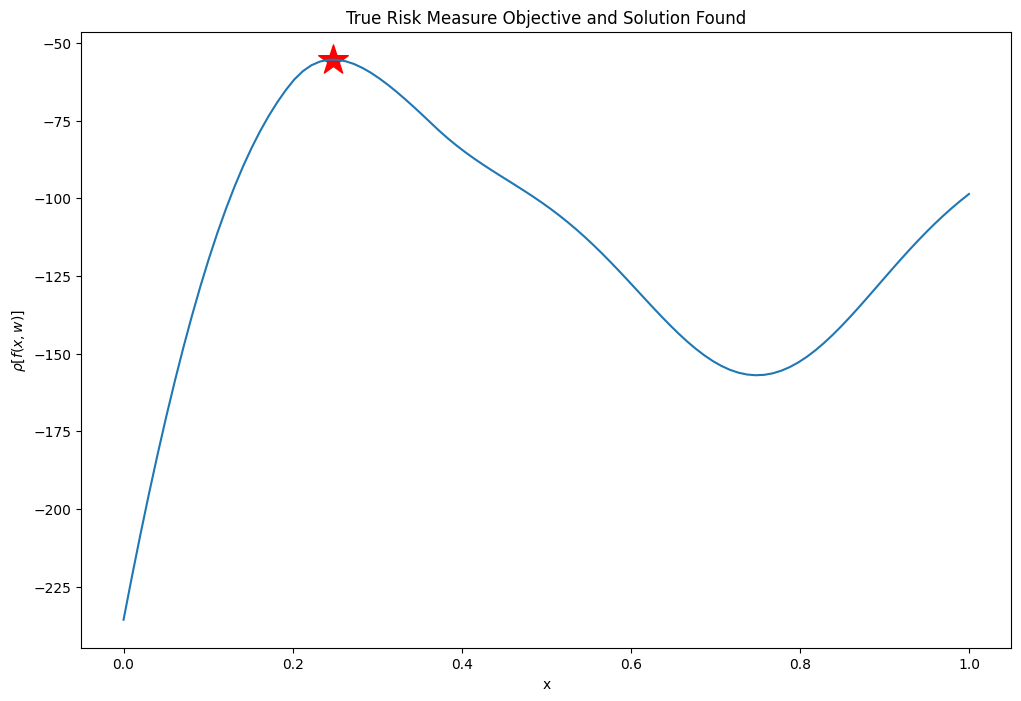

In [8]:
plot_x = torch.linspace(0, 1, 100, **tkwargs).view(-1, 1)
eval_X = new_transform(plot_x)
eval_Y = evaluate_function(eval_X)
plot_risk_measure = risk_measure(eval_Y)

plt.figure(figsize=(12, 8))
plt.title("True Risk Measure Objective and Solution Found")
plt.plot(plot_x, plot_risk_measure)
plt.scatter(final_candidate, expected_objective, marker="*", color="red", s=500)
plt.xlabel("x")
plt.ylabel("$\\rho[f(x, w)]$")
plt.show()